In [17]:
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
from torch import nn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score, classification_report
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve
plt.rcParams['font.family'] = 'SimHei'   # 黑体，Windows 自带
plt.rcParams['axes.unicode_minus'] = False  # 解决负号显示方块

In [5]:
# 1. 原始数据
df = pd.read_csv(r'E:\miniconda\ChineseSuperLeague\data\features.csv')
X = df[['home_last3_goals', 'away_last3_concede', 'home_last2_loss']].values
y = (df['result'] == 'H').astype(int).values

# 2. 先整体分层拆分（保持原始分布）
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

# 3. 只在训练集做 SMOTE
smote = SMOTE(random_state=42)
X_train_sm, y_train_sm = smote.fit_resample(X_train, y_train)
print(f'训练集：{np.bincount(y_train_sm)} 场（主胜已翻倍）')

训练集：[115 115] 场（主胜已翻倍）


In [6]:
scaler = StandardScaler()
X_train_sm = scaler.fit_transform(X_train_sm)
X_test     = scaler.transform(X_test)

X_train_sm = torch.tensor(X_train_sm, dtype=torch.float32)
X_test     = torch.tensor(X_test,  dtype=torch.float32)
y_train_sm = torch.tensor(y_train_sm, dtype=torch.float32).unsqueeze(1)
y_test     = torch.tensor(y_test,  dtype=torch.float32).unsqueeze(1)

In [9]:
class MLP_REG(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(3, 16),
            nn.BatchNorm1d(16),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(16, 8),
            nn.BatchNorm1d(8),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(8, 1)
        )
    def forward(self, x):
        return self.net(x)

model = MLP_REG()
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)


In [10]:
epochs = 300
train_losses, val_losses = [], []
best_val_loss = np.inf
patience, counter = 20, 0

for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    out = model(X_train_sm)
    loss = criterion(out, y_train_sm)
    loss.backward()
    optimizer.step()
    train_losses.append(loss.item())

    model.eval()
    with torch.no_grad():
        val_out = model(X_test)
        val_loss = criterion(val_out, y_test).item()
    val_losses.append(val_loss)

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        counter = 0
        torch.save(model.state_dict(), 'mlp_smote_best.pth')
    else:
        counter += 1
    if counter >= patience:
        print(f'早停于 epoch {epoch+1}')
        break
    if (epoch+1) % 50 == 0:
        print(f'Epoch {epoch+1:3d} | Train Loss = {loss.item():.4f} | Val Loss = {val_loss:.4f}')

Epoch  50 | Train Loss = 0.5997 | Val Loss = 0.6010
早停于 epoch 68


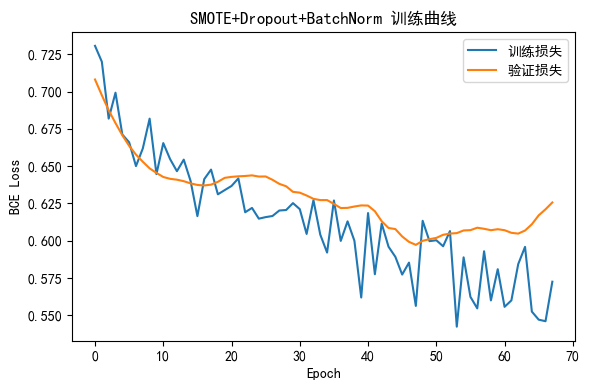

In [15]:
plt.figure(figsize=(6, 4))
plt.plot(train_losses, label='训练损失')
plt.plot(val_losses, label='验证损失')
plt.title('SMOTE+Dropout+BatchNorm 训练曲线')
plt.xlabel('Epoch'); plt.ylabel('BCE Loss')
plt.legend(); plt.tight_layout(); plt.show()

In [19]:
# Cell 7：阈值调优 + 最终报告（修复 nan + 细粒度搜索）
from sklearn.metrics import precision_recall_curve, f1_score

model.load_state_dict(torch.load('mlp_smote_best.pth'))
model.eval()
with torch.no_grad():
    logits = model(X_test)
    probs = torch.sigmoid(logits).numpy().squeeze(-1)

# 1. 0.05–0.95 每 0.05 扫一次，避开极端阈值
ths = np.arange(0.05, 1.0, 0.05)
f1s = []
for t in ths:
    y_pred = (probs >= t).astype(int)
    f1s.append(f1_score(y_test, y_pred))

# 2. 找最大 F1
best_idx = np.argmax(f1s)
best_th  = ths[best_idx]
print(f'最佳阈值={best_th:.2f} | 最大F1={f1s[best_idx]:.2f}')

# 3. 输出最终报告
y_pred = (probs >= best_th).astype(int)
print('\n'+classification_report(y_test, y_pred, target_names=['非主胜', '主胜']))

最佳阈值=0.50 | 最大F1=0.38

              precision    recall  f1-score   support

         非主胜       0.92      0.73      0.81        30
          主胜       0.27      0.60      0.38         5

    accuracy                           0.71        35
   macro avg       0.59      0.67      0.59        35
weighted avg       0.82      0.71      0.75        35

